
# Fine Tuning



Objectif : utiliser un réseau pré entraîné et une technique de Fine Tuning pour apprendre une classification de données personnelles. Les données étant en nombre insuffisant, une technique d'augmentation de données sera utilisée.

## Imports

In [1]:
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint


In [2]:
# Paramètres 
image_shape = (224, 224, 3)
image_size = image_shape[:2]

batch_size = 32
num_classes = 5


## Données 

In [5]:
def Data():
    data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos',cache_dir = '/Users/neil/Code/ZZ3/AI_ML/TP6/data',untar=True)
    data_dir = pathlib.Path(data_dir)

    print("Nombre d'images :", len(list(data_dir.glob('*/*.jpg'))))

    classes = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
    print("Classes : ",classes)

    # Augmentation de données : 75% entraînement, 25% test
    image_gen = ImageDataGenerator(
        rescale=1./255, 
        validation_split=0.25,
        rotation_range=45,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.2,
        zoom_range=.2,
        horizontal_flip=True,
        fill_mode='nearest'
        )
    # utiliser ImageDataGenerator

    # Augmentation de la base d'entraînement
    train_data_gen =  image_gen.flow_from_directory(directory=str(data_dir), target_size=image_size, batch_size=batch_size, subset='training')
    # Augmentation de la base de test/validation
    test_data_gen =  image_gen.flow_from_directory(directory=str(data_dir), target_size=image_size, batch_size=batch_size, subset='validation')
    return train_data_gen, test_data_gen, classes


In [31]:
def TransferModel(input_shape,stop_freeze):

    pretrained_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    # charger MobileNetV2
  
    # On ôte la dernière couche de classification
    pretrained_model.layers.pop()

    # On fige tous les poids sauf ceux des stop_freeze dernières couches
    for layer in pretrained_model.layers[:-stop_freeze]:
        layer.trainable = False

    # On rajoute en bout de réseau notre couche de classification pour le problème 
    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])
    
    return model
 

## Réseau 

In [32]:
num_epochs = 10
stop_freeze = 4

# Chargement des données augmentées
x_train, x_test, classes = Data()

# Modèle
model = TransferModel(input_shape=image_shape,stop_freeze = stop_freeze)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


# Callback pour la sauvegarde du meilleur modèle
if not os.path.isdir("sauve"):
    os.mkdir("sauve")
    
checkpoint = ModelCheckpoint("sauve/MobileNetV2_flowers-loss-{loss:.2f}-acc-{accuracy:.2f}.keras", save_best_only=True,verbose=1)

train_steps_epoch = int(np.ceil(x_train.samples / batch_size))
val_steps_epoch = int(np.ceil(x_test.samples / batch_size))

# Entraînement
model.fit(x_train, steps_per_epoch=train_steps_epoch,
                        validation_data=x_test, validation_steps=val_steps_epoch,
                        epochs=num_epochs, verbose=1, callbacks=[checkpoint])

Nombre d'images : 3670
Classes :  ['roses' 'sunflowers' 'daisy' 'dandelion' 'tulips']
Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.
Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7504 - loss: 0.6864
Epoch 1: val_loss improved from inf to 0.64584, saving model to sauve/MobileNetV2_flowers-loss-0.53-acc-0.81.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 23s 220ms/step - accuracy: 0.7511 - loss: 0.6846 - val_accuracy: 0.8208 - val_loss: 0.6458
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/10


2024-11-04 16:38:08.990224: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3153103109149856042
2024-11-04 16:38:08.990240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10460270197218942520
2024-11-04 16:38:08.990257: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10716230035425803790
2024-11-04 16:38:08.990259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17739634925810970815
2024-11-04 16:38:08.990273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794283945512907125
2024-11-04 16:38:08.990279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11785171951643980605
2024-11-04 16:38:08.990285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8852 - loss: 0.3219
Epoch 3: val_loss did not improve from 0.64584
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.8853 - loss: 0.3217 - val_accuracy: 0.7967 - val_loss: 0.8436
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/10


2024-11-04 16:38:26.942237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3153103109149856042
2024-11-04 16:38:26.942252: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10460270197218942520
2024-11-04 16:38:26.942259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10716230035425803790
2024-11-04 16:38:26.942266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794283945512907125
2024-11-04 16:38:26.942270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11785171951643980605
2024-11-04 16:38:26.942274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2225444363201008875
2024-11-04 16:38:26.942279: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9189 - loss: 0.2246
Epoch 5: val_loss did not improve from 0.64584
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.9188 - loss: 0.2247 - val_accuracy: 0.8109 - val_loss: 0.7553
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/10


2024-11-04 16:38:45.336251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3153103109149856042
2024-11-04 16:38:45.336266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10460270197218942520
2024-11-04 16:38:45.336272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10716230035425803790
2024-11-04 16:38:45.336293: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17739634925810970815
2024-11-04 16:38:45.336306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14670368571812358623
2024-11-04 16:38:45.336316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 17195267712791284871
2024-11-04 16:38:45.336319: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9309 - loss: 0.1937
Epoch 7: val_loss improved from 0.64584 to 0.64019, saving model to sauve/MobileNetV2_flowers-loss-0.21-acc-0.92.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.9309 - loss: 0.1938 - val_accuracy: 0.8317 - val_loss: 0.6402
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/10


2024-11-04 16:39:03.593841: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3153103109149856042
2024-11-04 16:39:03.593852: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10460270197218942520
2024-11-04 16:39:03.593860: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10716230035425803790
2024-11-04 16:39:03.593863: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794283945512907125
2024-11-04 16:39:03.593868: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14670368571812358623
2024-11-04 16:39:03.593873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11785171951643980605
2024-11-04 16:39:03.593878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9466 - loss: 0.1469
Epoch 9: val_loss improved from 0.64019 to 0.49612, saving model to sauve/MobileNetV2_flowers-loss-0.16-acc-0.94.keras
87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 195ms/step - accuracy: 0.9465 - loss: 0.1471 - val_accuracy: 0.8699 - val_loss: 0.4961
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00


2024-11-04 16:39:21.623897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 3153103109149856042
2024-11-04 16:39:21.623912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10460270197218942520
2024-11-04 16:39:21.623918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10716230035425803790
2024-11-04 16:39:21.623920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13794283945512907125
2024-11-04 16:39:21.623927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 14670368571812358623
2024-11-04 16:39:21.623931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11785171951643980605
2024-11-04 16:39:21.623936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous rec

In [33]:
# On construit le meilleur modèle appris
model = TransferModel(input_shape=image_shape,stop_freeze=2 )
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.load_weights("sauve/MobileNetV2_flowers-loss-0.15-acc-0.95.keras")

# Evaluation du modèle
evaluation = model.evaluate(x_test, steps=val_steps_epoch, verbose=1)
print("Perte = {0:5.3f}, Précision = {1:5.3f}".format(evaluation[0], evaluation[1]))

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.8626 - loss: 0.4607
Perte = 0.483, Précision = 0.860


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


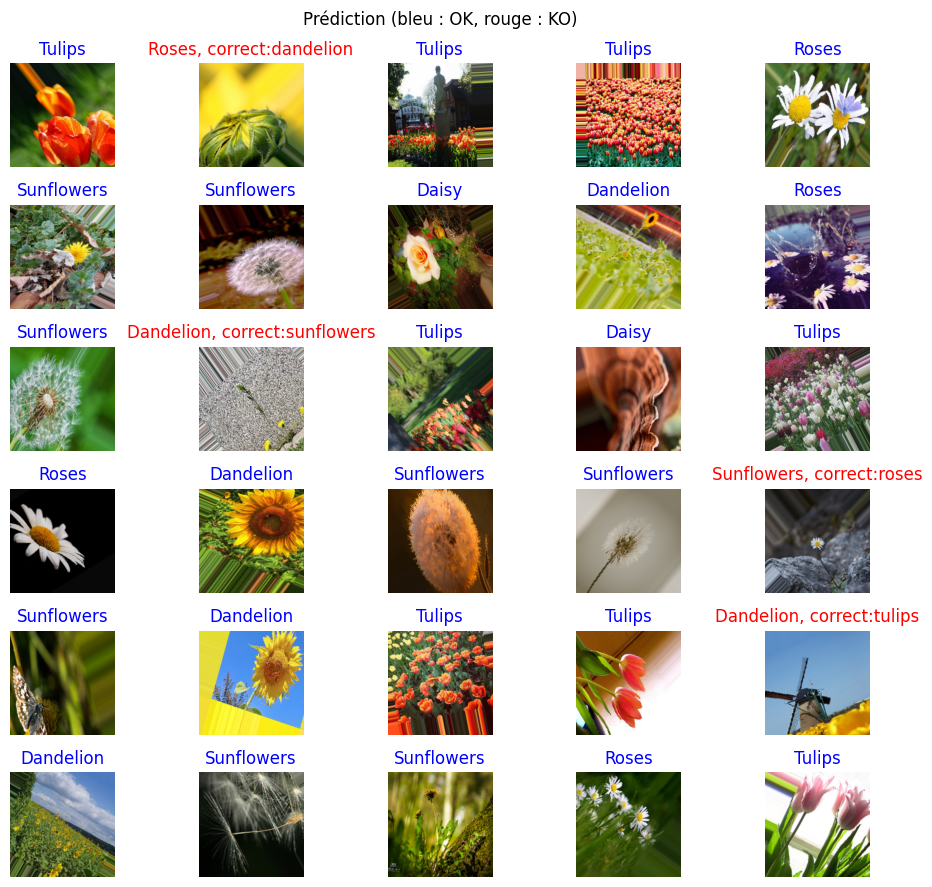

In [37]:
# Quelques exemples de bonne / mauvaise classification
image_batch, label_batch = next(iter(x_test))

label_batch = [classes[np.argmax(label_batch[i])] for i in range(batch_size)]
predicted_classes = model.predict(image_batch)

predicted_ids = [np.argmax(predicted_classes[i]) for i in range(batch_size)]
predicted_classes = np.array([classes[id] for id in predicted_ids])

plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_classes[n] == label_batch[n]:
        color = "blue"
        title = predicted_classes[n].title()
    else:
        color = "red"
        title = f"{predicted_classes[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Prédiction (bleu : OK, rouge : KO)")
plt.tight_layout()
plt.savefig("res.png",dpi=100)